In [1]:
from ultralytics import YOLO

import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
import torch
import os
from sklearn.model_selection import train_test_split

/storage/conda/envs/env_qc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ultralytics import SAM
from ultralytics import FastSAM

In [3]:
from src.dataset import PascalPartDataset
# from lightning_module import PascalPartModel

In [4]:
import pytorch_lightning as pl
seed = 142
pl.seed_everything(seed=seed, workers=True)


Seed set to 142


142

In [5]:

# import segmentation_models_pytorch as smp

# encoder = smp.MAnet(
#             # encoder_name=encoder_name,        
#             # encoder_weights=encoder_weights,  
#             classes=2,                     
#             activation=None                   
#         )


In [6]:
# df_train_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
# df_val_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})

# # extract names of images and masks for train and val splts
# splits = ["train_id", "val_id"]
# splits_samples = {}

# for split in splits:
#     with open(f'/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/data/{split}.txt') as f:
#         splits_samples[split] = f.read().splitlines()

# path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/Pascal-part'

# # create dataframes with full paths to images and masks
# df_train_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['train_id']]
# df_train_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['train_id']]
# df_val_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/JPEGImages/{id_img}.jpg' for id_img in splits_samples['val_id']]
# df_val_paths['PATH_TO_MASK'] = [f'{path_to_raw}/gt_masks/{id_mask}.npy' for id_mask in splits_samples['val_id']]

In [7]:
path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part'
    
names_images = os.listdir('/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/big_mask_samples/JPEGImages/')
names_images = sorted(names_images)

names_masks = os.listdir('/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/big_mask_samples/gt_masks/')
names_masks = sorted(names_masks)

train_idx, val_idx = train_test_split(list(range(len(names_images))), train_size=0.8)

df_train_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})
df_val_paths = pd.DataFrame({'PATH_TO_IMAGE': [], 'PATH_TO_MASK': []})

# Create DataFrames with full paths to images and masks for training and validation sets
df_train_paths['PATH_TO_IMAGE'] = [f'{path_to_raw}/big_mask_samples/JPEGImages/{names_images[idx]}' for idx in train_idx]
df_train_paths['PATH_TO_MASK'] = [f'{path_to_raw}/big_mask_samples/gt_masks/{names_masks[idx]}' for idx in train_idx]
df_val_paths['PATH_TO_IMAGE'] =  [f'{path_to_raw}/big_mask_samples/JPEGImages/{names_images[idx]}' for idx in val_idx]
df_val_paths['PATH_TO_MASK'] = [f'{path_to_raw}/big_mask_samples/gt_masks/{names_masks[idx]}' for idx in val_idx]


In [8]:
transform = A.Compose([
        A.Resize(256, 256),
        # A.Resize(256, 256),
        # A.Normalize(
        #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        #     # max_pixel_value=255.0,
        # ),
        # ToTensorV2()
    ])

In [9]:
# Create the dataset and dataloader
val_dataset = PascalPartDataset(
    df_val_paths,
    # transform=transform
)
train_dataset = PascalPartDataset(
    df_train_paths, 
    # transform=transform
)

In [10]:
from torch.utils.data import DataLoader

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=63)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=63)

# YOLOv8 Pose Estimation

In [12]:
# Load a model
model_pose = YOLO("yolov8s-pose.pt")  # load a pretrained model 

# # Train the model
# results = model.train(data="coco8-pose.yaml", epochs=100, imgsz=640)

In [13]:
transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
            # max_pixel_value=255.0,
        ),
        ToTensorV2()
    ])

In [14]:
path_to_image = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/big_mask_samples/JPEGImages/2008_003884.jpg'
path_to_mask = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/big_mask_samples/gt_masks/2008_003884.npy'

print(path_to_image)
print(path_to_mask)
    
# Load the image using OpenCV
image = cv2.imread(path_to_image)
# Convert the image from BGR (OpenCV default) to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the mask from the numpy file
mask = np.load(path_to_mask)


transformed = transform(image=image, mask=mask)
tf_image = transformed['image']
tf_mask = transformed['mask']

/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/big_mask_samples/JPEGImages/2008_003884.jpg
/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/big_mask_samples/gt_masks/2008_003884.npy


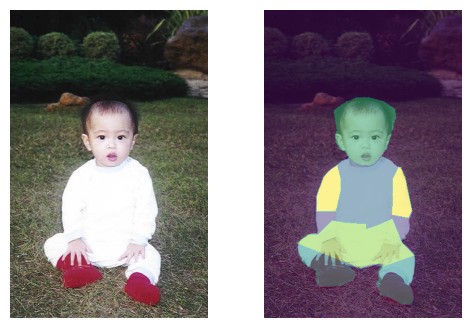

In [30]:
plt.figure(figsize=(6, 4))


plt.subplot(1, 2, 1)

plt.imshow(image ) # .permute(1, 2, 0).cpu().numpy())
# plt.imshow(mask, alpha=0.5) # .permute(1, 2, 0).cpu().numpy(), alpha=0.5)
plt.axis('off')

plt.subplot(1, 2, 2)

plt.imshow(image ) # .permute(1, 2, 0).cpu().numpy())
plt.imshow(mask, alpha=0.5) # .permute(1, 2, 0).cpu().numpy(), alpha=0.5)
plt.axis('off')



plt.show()

In [21]:
# idx = 10
# image, mask = val_dataset[idx]

# transformed = transform(image=image, mask=mask)
# image = transformed['image']
# mask = transformed['mask']

# plt.imshow(image ) # .permute(1, 2, 0).cpu().numpy())
# # plt.imshow(mask, alpha=0.5) # .permute(1, 2, 0).cpu().numpy(), alpha=0.5)
# plt.axis('off')
# plt.show()



0: 256x192 1 person, 68.4ms
Speed: 2.9ms preprocess, 68.4ms inference, 160.0ms postprocess per image at shape (1, 3, 256, 192)


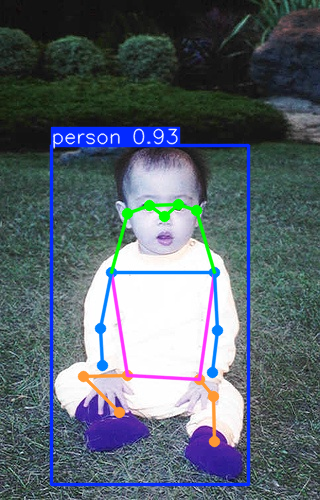

In [22]:
res_pose = model_pose.predict(
    image,
    # batch,
    # iou=0.999,
    # conf=0.001, 
    imgsz=256,
    # device='cpu'
) 

res_pose[0].show()

In [23]:
# Extract keypoints and bounding boxes
points, labels, bboxes = [], [], []
for r in res_pose:
    tmp_points = np.array(r.keypoints.xy.reshape((-1, 2)).cpu().tolist() + [[0, 0]], dtype=np.uint8)
    points.append(tmp_points)
    labels.append(np.arange(len(tmp_points)).astype(np.uint8))
    tmp_bboxes = np.array(r.boxes.xywh.reshape((-1, 4)).cpu().tolist() + [[0, 0, 0, 0]], dtype=np.uint8)
    bboxes.append(tmp_bboxes)

In [24]:
print(np.array(points).shape, np.array(labels).shape, np.array(bboxes).shape)

(1, 18, 2) (1, 18) (1, 2, 4)


In [25]:
res_pose[0].boxes.xywh

tensor([[149.5000, 314.5000, 197.0000, 339.0000]], device='cuda:0')

# SAM

In [26]:
# # Load a model
# model = SAM("sam_b.pt")

# Create a FastSAM model
model_sam = FastSAM("FastSAM-s.pt") 

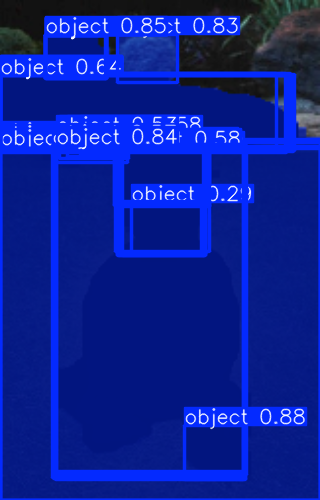

In [27]:
res_seg = model_sam.predict(
                source=image,
                half=True,
                verbose=False,
                iou=0.99,
                imgsz=256,
                points=points[0],
                labels=labels[0],
                bboxes=bboxes[0],
                # texts='human, body parts'
            )
res_seg[0].show()

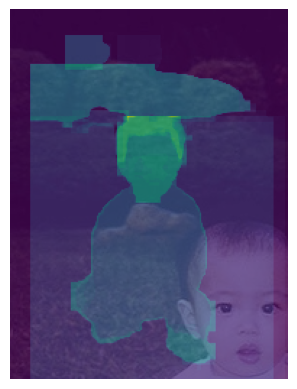

In [28]:
final_mask = torch.sum(res_seg[0].masks.data.cpu(), dim=0)

plt.imshow(res_seg[0].orig_img)
plt.imshow(final_mask , alpha=0.75)
plt.axis('off')
plt.show()